In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from graph_tool.all import *
import networkx as nx
import collections
import scipy as sp

from scipy.sparse import dok_matrix

import modules

openmp_set_num_threads(6)

# Helper functions

In [2]:
def filter_lone_vertices(g):
    """
    Return a GraphView that filters out unconnected vertices.
    """
    vmask = g.new_vertex_property("bool")
    vmask.fa = g.degree_property_map("total").fa != 0

    return GraphView(g, vfilt = vmask)

def all_path_of_length(g, source, target, length, only_unique=False):
    for path in all_paths(g, source, target, cutoff=length, edges=False):
        if len(path) == length:
            if only_unique:
                if len(path) == len(set(path)):
                    yield path
            else:
                yield path

def make_structured_edge_graph(g, l=1):
    #for ease we make a reverse copy since adjacency a_ij in graph-tool gives presence of edge from j to i
    g_reverse = GraphView(g, reversed=True)

    #finding nodes connected through paths of length l
    c_paths = dict(dok_matrix(adjacency(g_reverse, weight=None)**l))

    reached=set()
    path_nodes = [] #we fill this list with paths of length l we eventually want to make nodes out of in path space
    for i in c_paths.keys():
        source = i[0]
        target = i[1]
        #if source!=target: #no cycle path
        for path in all_path_of_length(g, source, target, l+1):
            path_nodes.append(path)

    reached = reached.union(set([item for l in path_nodes for item in l]))        
    unreached = set(g.get_vertices()).difference(reached)

    sub_l_path_nodes = [] #here we store paths shorter than l for which we will make isolated nodes in path space
    for sub_l in np.arange(l-1,0,-1): #we check if we can reach the nodes not reached with pathlength l with paths of length l,...,1
        sub_l_paths = dok_matrix(adjacency(g, weight=None)**sub_l) #here we use the non-reversed g because it will be easier to find the sources for a given target
        sub_l_reachable_nodes = set([item for tup in sub_l_paths.keys() for item in tup])
        for node in unreached.intersection(sub_l_reachable_nodes):
            unreached.remove(node)
            sources = []
            for temp_link in dict(sub_l_paths[node]).keys():
                sources.append(temp_link[1])
            for source in sources:
                for path in all_shortest_paths(g, source, node):
                    sub_l_path_nodes.append(path)

    #adding isolated nodes
    sub_l_path_nodes += list(unreached)

    #adding the nodes directly in a structured dict of lists representation of a network (input for the structural controllability code)
    structured_path_matrix = {}
    for i in path_nodes:
        str_i = '-'.join(map(str, i)) #represent a path a-b-c as string 'a-b-c' just for convenience in debugging
        structured_path_matrix.setdefault(str_i,[])
        for j in path_nodes:
            if np.array_equal(i[1:],j[:-1]):
            #if any(np.array_equal(i[k:],j[:-k]) for k in range(1, len(i)-1)):
                str_j = '-'.join(map(str, j))
                structured_path_matrix.setdefault(str_i,[])
                structured_path_matrix[str_i].append(str_j)

    for i in sub_l_path_nodes:
        if type(i) == int or type(i) == np.int64:
            structured_path_matrix.setdefault(str(i),[])
        else:
            str_i = '-'.join(map(str, i))
            structured_path_matrix.setdefault(str_i,[])
    
    return structured_path_matrix

# Consultant network

data downloaded from: http://opsahl.co.uk/tnet/datasets/Cross_Parker-Consulting_info.txt (last accessed 11 nov 2021)

## Read in data and make network

In [3]:
from graph_tool.all import *

#opens your file in mode "read"
f = open("data/consulting_net.txt","r")
#splits each line into a list of integers
lines = [[(int(n)-1) for n in x.split()[:-1]] for x in f.readlines()]
#closes the file
f.close()

#makes the graph
g = Graph()
#adds enough vertices (the "1 + " is for position 0)
g.add_vertex(1 + max([l[0] for l in lines] + [l[1] for l in lines]))

#for each line
for i,line in enumerate(lines):
    #make a new edge
    g.add_edge(g.vertex(int(line[1])),g.vertex(int(line[0])))

In [4]:
max([l[0] for l in lines] + [l[1] for l in lines])

45

## calculate node controllability n<sub>D

In [5]:
matches, unmatched = modules.bipartiteMatchHK(g, matching={})
driver_nodes = set()
if len(unmatched) == 0:
    print(1/g.num_vertices())
else:
    print(len(unmatched)/g.num_vertices())

0.043478260869565216


## calculate edge controllability n<sub>D

In [6]:
#does maximum matching for network in its edge space representation
matches, unmatched = modules.bipartiteMatchHK(make_structured_edge_graph(Graph(filter_lone_vertices(g),prune=True)), matching={})

#takes the originating node for the driver edges in node space to get to n_D
driver_nodes = set()
if len(unmatched) == 0:
    print(1/n)
else:
    for i in unmatched:
        nodes = i.split('-')
        driver_nodes.add(nodes[0])
    print(len(driver_nodes)/g.num_vertices())

Reading in graph as given dict, make sure it has the form {[from]:[to]} for all nodes.
0.5217391304347826


# Ownership-USCorp network

data downloaded from: http://vlado.fmf.uni-lj.si/pub/networks/data/econ/Eva/Eva.htm (last accessed 11 nov 2021)

## Read in data and make network

In [7]:
from graph_tool.all import *

#opens your file in mode "read"
f = open("data/ownership.txt","r")
#splits each line into a list of integers
lines = [[(int(n)-1) for n in x.split()] for x in f.readlines()]
#closes the file
f.close()

We make a dictionary to map the company numbers in the text file to a sequential list of numbers for the nodes since the company numbering goes up to 8343 but there are only 7253 unique companies in the data.

In [8]:
source = set([l[0] for l in lines])
target = set([l[1] for l in lines])
unique_company_numbers = sorted(source.union(target))
unique_node_numbers = list(range(0,len(unique_company_numbers)))
company_to_node_mapping = dict(zip(unique_company_numbers, unique_node_numbers))

In [9]:
max(unique_node_numbers)

7252

In [10]:
#makes the graph
g = Graph()
#adds enough vertices (the "1 + " is for position 0)
g.add_vertex(1 + max(unique_node_numbers))

#for each line
for i,line in enumerate(lines):
    #make a new edge
    g.add_edge(g.vertex(company_to_node_mapping[int(line[0])]),g.vertex(company_to_node_mapping[int(line[1])]))

## calculate node controllability n<sub>D

In [11]:
matches, unmatched = modules.bipartiteMatchHK((Graph(filter_lone_vertices(g),prune=True)), matching={})
driver_nodes = set()
if len(unmatched) == 0:
    print(1/g.num_vertices())
else:
    print(len(unmatched)/g.num_vertices())

0.8203501999172756


## calculate edge controllability n<sub>D

In [12]:
#does maximum matching for network in its edge space representation
matches, unmatched = modules.bipartiteMatchHK(make_structured_edge_graph(Graph(filter_lone_vertices(g),prune=True)), matching={})

#takes the originating node for the driver edges in node space to get to n_D
driver_nodes = set()
if len(unmatched) == 0:
    print(1/n)
else:
    for i in unmatched:
        nodes = i.split('-')
        driver_nodes.add(nodes[0])
    print(len(driver_nodes)/g.num_vertices())

Reading in graph as given dict, make sure it has the form {[from]:[to]} for all nodes.
0.15952019853853577


# Network simulations

## Skip this whole block if you just want to load in the simulations used for the paper

The networks are generated by passing the right discrete degree distribution generator to the random_graph function in graph_tool

In [ ]:
#amount of nodes
n=10000

## Erdos-Renyi (poisson degree distribution)

In [ ]:
from scipy.stats import poisson

def gen_poisson_pair(mu = 1):
    return(poisson.rvs(mu, size=1)[0],poisson.rvs(mu, size=1)[0])

In [ ]:
Poisson_node_n_D = list()
Poisson_edge_n_D = list()
Poisson_k_mean = list()
for mu in [0,0.01,0.05,0.08,0.1,0.15,0.2,0.25,0.3,0.5,0.7,0.9,1,2,3,4,5,6,7,8,9,10]:
    G = random_graph(n, lambda : gen_poisson_pair(mu=mu), directed = True)
    Poisson_k_mean.append(np.mean(list(G.degree_property_map(deg='total').a)))
    matches, unmatched = modules.bipartiteMatchHK(G, matching={})
    if len(unmatched) == 0:
        Poisson_node_n_D.append(1/n)
    else:
        Poisson_node_n_D.append(len(unmatched)/n)
    
    matches, unmatched = modules.bipartiteMatchHK(make_structured_edge_graph(Graph(filter_lone_vertices(G),prune=True)), matching={})
    driver_nodes = set()
    if len(unmatched) == 0:
        Poisson_edge_n_D.append(1/n)
    else:
        for i in unmatched:
            nodes = i.split('-')
            driver_nodes.add(nodes[0])
        Poisson_edge_n_D.append(len(driver_nodes)/n)
        
    print('Mean degree: ',Poisson_k_mean[-1])
    print('Node n_d: ',Poisson_node_n_D[-1])
    print('Edge n_d: ',Poisson_edge_n_D[-1])
    print('Writing to file...')

    # open a file, where you ant to store the data
    file = open('Poisson_node_n_D.pkl', 'wb')

    # dump information to that file
    pickle.dump(Poisson_node_n_D, file)

    # close the file
    file.close()

    # open a file, where you ant to store the data
    file = open('Poisson_edge_n_D.pkl', 'wb')

    # dump information to that file
    pickle.dump(Poisson_edge_n_D, file)

    # close the file
    file.close()

    # open a file, where you ant to store the data
    file = open('Poisson_k_mean.pkl', 'wb')

    # dump information to that file
    pickle.dump(Poisson_k_mean, file)

    # close the file
    file.close()

In [ ]:
Poisson_node_n_D, Poisson_edge_n_D,Poisson_k_mean

## Exponential networks (geometric degree distribution)

In [ ]:
from scipy.stats import geom

def gen_geom_pair(p = 0.1):
    return(geom.rvs(p,loc=-1, size=1)[0],geom.rvs(p,loc=-1, size=1)[0])

In [ ]:
Geom_node_n_D = list()
Geom_edge_n_D = list()
Geom_k_mean = list()
for p in [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.08,0.06,0.04]:
    G = random_graph(n, lambda : gen_geom_pair(p=p), directed = True)
#     pos = sfdp_layout(G)
#     graph_draw(G, pos=pos, output="graph-draw-sfdp{}.pdf".format(p))
    Geom_k_mean.append(np.mean(list(G.degree_property_map(deg='total').a)))
    matches, unmatched = modules.bipartiteMatchHK(G, matching={})
    if len(unmatched) == 0:
        Geom_node_n_D.append(1/n)
    else:
        Geom_node_n_D.append(len(unmatched)/n)
    
    matches, unmatched = modules.bipartiteMatchHK(make_structured_edge_graph(Graph(filter_lone_vertices(G),prune=True)), matching={})
    driver_nodes = set()
    if len(unmatched) == 0:
        Geom_edge_n_D.append(1/n)
    else:
        for i in unmatched:
            nodes = i.split('-')
            driver_nodes.add(nodes[0])
        Geom_edge_n_D.append(len(driver_nodes)/n)
        
    print('Mean degree: ',Geom_k_mean[-1])
    print('Node n_d: ',Geom_node_n_D[-1])
    print('Edge n_d: ',Geom_edge_n_D[-1])
    print('Writing to file...')

    # open a file, where you ant to store the data
    file = open('Geom_node_n_D.pkl', 'wb')

    # dump information to that file
    pickle.dump(Geom_node_n_D, file)

    # close the file
    file.close()

    # open a file, where you ant to store the data
    file = open('Geom_edge_n_D.pkl', 'wb')

    # dump information to that file
    pickle.dump(Geom_edge_n_D, file)

    # close the file
    file.close()

    # open a file, where you ant to store the data
    file = open('Geom_k_mean.pkl', 'wb')

    # dump information to that file
    pickle.dump(Geom_k_mean, file)

    # close the file
    file.close()

In [ ]:
Geom_node_n_D, Geom_edge_n_D, Geom_k_mean

## Scale-free network (zipf-law degree distribution)
Not included in paper because connection to mean degree (\<k>) not straightforward and simulation-dependent. See Fig S6 in SI of Liu, Slotine, and Barabasi (2011) (https://static-content.springer.com/esm/art%3A10.1038%2Fnature10011/MediaObjects/41586_2011_BFnature10011_MOESM274_ESM.pdf)

from scipy.stats import zipf

def gen_zipf_pair(a = 2.5):
    return(zipf.rvs(a, loc=-1,size=1)[0],zipf.rvs(a,loc=-1, size=1)[0])

Zipf_node_n_D = list()
Zipf_edge_n_D = list()
Zipf_k_mean = list()
for a in [5,4,3.7,3.3,3,2.8,2.5,2.3,2,1.8,1.7,1.6,1.5,1.4,1.3]:
    G = random_graph(n, lambda : gen_zipf_pair(a=a), directed = True)
    Zipf_k_mean.append(np.mean(list(G.degree_property_map(deg='total').a)))
    matches, unmatched = modules.bipartiteMatchHK(G, matching={})
    if len(unmatched) == 0:
        Zipf_node_n_D.append(1/n)
    else:
        Zipf_node_n_D.append(len(unmatched)/n)
    
    matches, unmatched = modules.bipartiteMatchHK(make_structured_edge_graph(Graph(filter_lone_vertices(G),prune=True)), matching={})
    driver_nodes = set()
    if len(unmatched) == 0:
        Zipf_edge_n_D.append(1/n)
    else:
        for i in unmatched:
            nodes = i.split('-')
            driver_nodes.add(nodes[0])
        Zipf_edge_n_D.append(len(driver_nodes)/n)
        
    print('Mean degree: ',Zipf_k_mean[-1])
    print('Node n_d: ',Zipf_node_n_D[-1])
    print('Edge n_d: ',Zipf_edge_n_D[-1])
    print('Writing to file...')

    # open a file, where you ant to store the data
    file = open('Zipf_node_n_D_n10000.pkl', 'wb')

    # dump information to that file
    pickle.dump(Zipf_node_n_D, file)

    # close the file
    file.close()

    # open a file, where you ant to store the data
    file = open('Zipf_edge_n_D_n10000.pkl', 'wb')

    # dump information to that file
    pickle.dump(Zipf_edge_n_D, file)

    # close the file
    file.close()

    # open a file, where you ant to store the data
    file = open('Zipf_k_mean_n10000.pkl', 'wb')

    # dump information to that file
    pickle.dump(Zipf_k_mean, file)

    # close the file
    file.close()

Zipf_node_n_D, Zipf_edge_n_D, Zipf_k_mean

# Plotting

## loading in data (optional if above simulations are in memory)

In [13]:
load_new_simulations = False
prefix = 'simulation_output/'
if load_new_simulations:
    prefix=''

file = open(prefix+'Geom_k_mean.pkl', 'rb')
Geom_k_mean = pickle.load(file)
file.close()

# open a file, where you stored the pickled data
file = open(prefix+'Geom_edge_n_D.pkl', 'rb')
# dump information to that file
Geom_edge_n_D = pickle.load(file)
# close the file
file.close()

# open a file, where you stored the pickled data
file = open(prefix+'Geom_node_n_D.pkl', 'rb')
# dump information to that file
Geom_node_n_D = pickle.load(file)
# close the file
file.close()

# open a file, where you stored the pickled data
file = open(prefix+'Poisson_k_mean.pkl', 'rb')
# dump information to that file
Poisson_k_mean = pickle.load(file)
# close the file
file.close()

# open a file, where you stored the pickled data
file = open(prefix+'Poisson_edge_n_D.pkl', 'rb')
# dump information to that file
Poisson_edge_n_D = pickle.load(file)
# close the file
file.close()

# open a file, where you stored the pickled data
file = open(prefix+'Poisson_node_n_D.pkl', 'rb')
# dump information to that file
Poisson_node_n_D = pickle.load(file)
# close the file
file.close()

# # open a file, where you stored the pickled data
# file = open(prefix+'Zipf_k_mean_n10000.pkl', 'rb')
# # dump information to that file
# Zipf_k_mean = pickle.load(file)
# # close the file
# file.close()

# # open a file, where you stored the pickled data
# file = open(prefix+'Zipf_edge_n_D_n10000.pkl', 'rb')
# # dump information to that file
# Zipf_edge_n_D = pickle.load(file)
# # close the file
# file.close()

# # open a file, where you stored the pickled data
# file = open(prefix+'Zipf_node_n_D_n10000.pkl', 'rb')
# # dump information to that file
# Zipf_node_n_D = pickle.load(file)
# # close the file
# file.close()

# Generate Fig 3

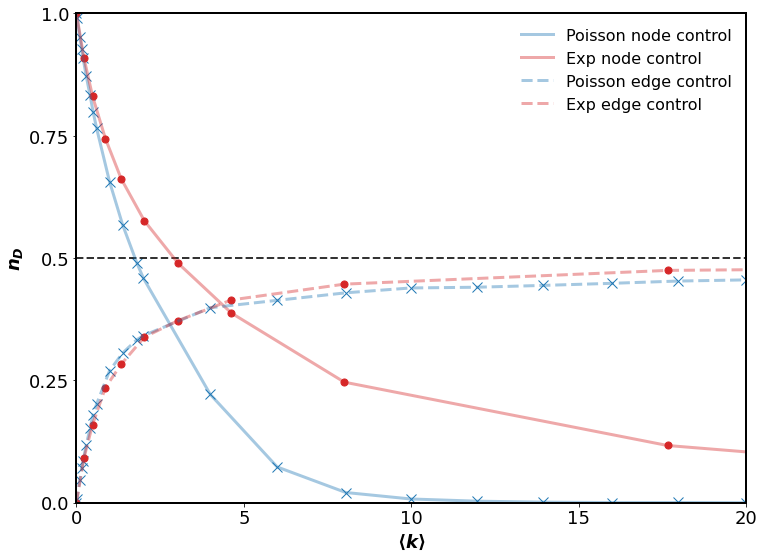

In [14]:
import matplotlib
xmin = 0
xmax = 20
ymin = 0
ymax = 1
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# You typically want your plot to be ~1.33x wider than tall. This plot is a rare    
# exception because of the number of lines being plotted on it.    
# Common sizes: (10, 7.5) and (12, 9)    
#plt.figure(figsize=(12, 14))
plt.figure(figsize=(12, 9)) 
matplotlib.rcParams['axes.linewidth'] = 2

  
# Remove the plot frame lines. They are unnecessary chartjunk.    
ax = plt.subplot(111)    
# ax.spines["top"].set_visible(False)    
# ax.spines["bottom"].set_visible(False)    
# ax.spines["right"].set_visible(False)    
# ax.spines["left"].set_visible(False)
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.    
# Ticks on the right and top of the plot are generally unnecessary chartjunk.    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
  
# Limit the range of the plot to only where the data is.    
# Avoid unnecessary whitespace.    
plt.ylim(ymin, ymax)    
plt.xlim(xmin, xmax)    
  
# Make sure your axis ticks are large enough to be easily read.    
# You don't want your viewers squinting to read your plot.    
plt.yticks(np.arange(ymin, ymax+0.25, 0.25), [str(np.round(x,3)) + "" for x in np.arange(ymin, ymax+0.25, 0.25)], fontsize=18)
plt.xticks(np.arange(xmin, xmax+5, 5), [str(np.round(x,1)) + "" for x in np.arange(xmin, xmax+5,5)], fontsize=18)    

plt.plot(range(xmin, xmax+1), [0.5] * len(range(xmin, xmax+1)), "--", lw=2, color="black", alpha=0.8)

#Remove the tick marks; they are unnecessary with the tick lines we just plotted.    
plt.tick_params(axis="both", which="both", bottom="on", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on") 

# Now that the plot is prepared, it's time to actually plot the data!    
plt.scatter(Poisson_k_mean,Poisson_node_n_D,marker='x',s=100,alpha=1,lw=1, color=tableau20[0])
plt.scatter(Geom_k_mean,Geom_node_n_D,marker='o',s=50,alpha=1,lw=1, color=tableau20[6])

plt.plot(Poisson_k_mean,Poisson_node_n_D,'-',lw=3,alpha=.4, color=tableau20[0], label = 'Poisson node control')
plt.plot(Geom_k_mean,Geom_node_n_D,'-',lw=3,alpha=.4, color=tableau20[6], label = 'Exp node control')


plt.scatter(Poisson_k_mean,Poisson_edge_n_D,marker='x',s=100,alpha=1, lw=1, color=tableau20[0])
plt.scatter(Geom_k_mean,Geom_edge_n_D,marker='o',s=50,alpha=1, lw=1, color=tableau20[6])

plt.plot(Poisson_k_mean,Poisson_edge_n_D,'--',lw=3,alpha=.4, color=tableau20[0], label = 'Poisson edge control')
plt.plot(Geom_k_mean,Geom_edge_n_D,'--',lw=3,alpha=.4, color=tableau20[6], label = 'Exp edge control')

## matplotlib's title() call centers the title on the plot, but not the graph,    
# so I used the text() call to customize where the title goes.    
  
# Make the title big enough so it spans the entire plot, but don't make it    
# so big that it requires two lines to show.
ax.tick_params(top=False)
ax.tick_params(right=False)
  
# Note that if the title is descriptive enough, it is unnecessary to include    
# axis labels; they are self-evident, in this plot's case.    
#plt.text(xmin + (xmax-xmin)/2, ymax+ 0.2, "Percentage income increase of person in 75th percentile of starting wealth \n vs person in 25th percentile, for different controls (3-10 years into one's career)", fontsize=17, ha="center")    
#plt.title("Percentage income difference for different personal characteristics (3-10 years into one's career)")    
plt.ylabel('$n_D$', fontsize=18)
plt.xlabel(r'$\langle k \rangle$',fontsize=18)
plt.legend(prop={'size': 16}, frameon=False)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.weight": 700,
})
# Finally, save the figure as a PNG.    
# You can also save it as a PDF, JPEG, etc.    
# Just change the file extension in this call.    
# bbox_inches="tight" removes all the extra whitespace on the edges of your plot.    
plt.savefig("fig3.pdf", bbox_inches='tight')  